In [1]:
import sys
import numpy as np

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
%matplotlib inline

In [4]:
sys.path.append("/home/joshuasobrin/spt3g/spt3g_software/build")

In [5]:
from spt3g import core, mapmaker, coordinateutils
from spt3g.std_processing import combining_maps
from spt3g.util import fitting
from spt3g.mapspectra import basicmaputils

# Define plotting parameters #

In [6]:
def plot_spt3g_map(input_map, pixel_mask=None, fig=None, title=''):
    
    if isinstance(input_map, coordinateutils.FlatSkyMap):
        if input_map.is_weighted:
            print('Input map is marked as weighted, '
                  'but plotting will proceed')
        tmap_original = input_map
    
    if pixel_mask is None:
        pixel_mask = np.isfinite(np.asarray(tmap_original))
    
    #plot in uK
    tmap = tmap_original/core.G3Units.uK
    
    # Figure out an appropriate colorscale
    sdtemp = np.nanstd(np.array(tmap)[np.where(pixel_mask)])
    if sdtemp == 0 or not np.isfinite(sdtemp):
        raise ValueError(
            "Map has zero or non-finite RMS.")
    atemp = fitting.gaussfit_hist(
        np.array(tmap)[np.where(pixel_mask)], 1000,
        -5.*sdtemp, 5.*sdtemp, do_plot = False)
    
    # Now that we're done using it as an indexing bool,
    # use pixel_mask as plotting mask
    pixel_mask = np.array(pixel_mask, dtype = float)
    pixel_mask[np.where(pixel_mask == 0.)] = np.nan

    # Make the plot
    plt.figure(fig, figsize=(30,15))
    ax = plt.gca()
    im = ax.imshow(tmap*pixel_mask,
                   origin='lower', cmap=plt.cm.gray,
                   interpolation = None,
                   vmin = -5.*atemp['params'][2],
                   vmax = 5.*atemp['params'][2])
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0)

    cbar = plt.colorbar(im, cax = cax)
    cbar.set_label("$K_{CMB}$", labelpad = -10)
    cbar.ax.tick_params(axis='y',width=0,length=0)
    plt.tight_layout()

# Make the final coadded map #

In [7]:
bundle_list = ["/spt/user/joshuasobrin/clusters/2019-08-31_map_products/partial_coadd_201906_150_a.g3",
               "/spt/user/joshuasobrin/clusters/2019-08-31_map_products/partial_coadd_201906_150_b.g3"]

In [8]:
combining_maps.coadd_maps(bundle_list, output_file="/spt/user/joshuasobrin/clusters/2019-08-31_map_products/full_coadd_201906_150.g3")

In [9]:
full_coadd = core.G3File("/spt/user/joshuasobrin/clusters/2019-08-31_map_products/full_coadd_201906_150.g3")
full_coadd = full_coadd.next()

In [10]:
removed_weights_full_coadd = mapmaker.mapmakerutils.remove_weight_t(full_coadd["T"], full_coadd["Wunpol"])

In [11]:
#Save the map in fits-format (in Kelvin-units)
mapmaker.mapmakerutils.save_spt3g_map("/spt/user/joshuasobrin/clusters/2019-08-31_map_products/full_coadd_201906_150.fits", removed_weights_full_coadd/core.G3Units.K, old_style_fits=True)

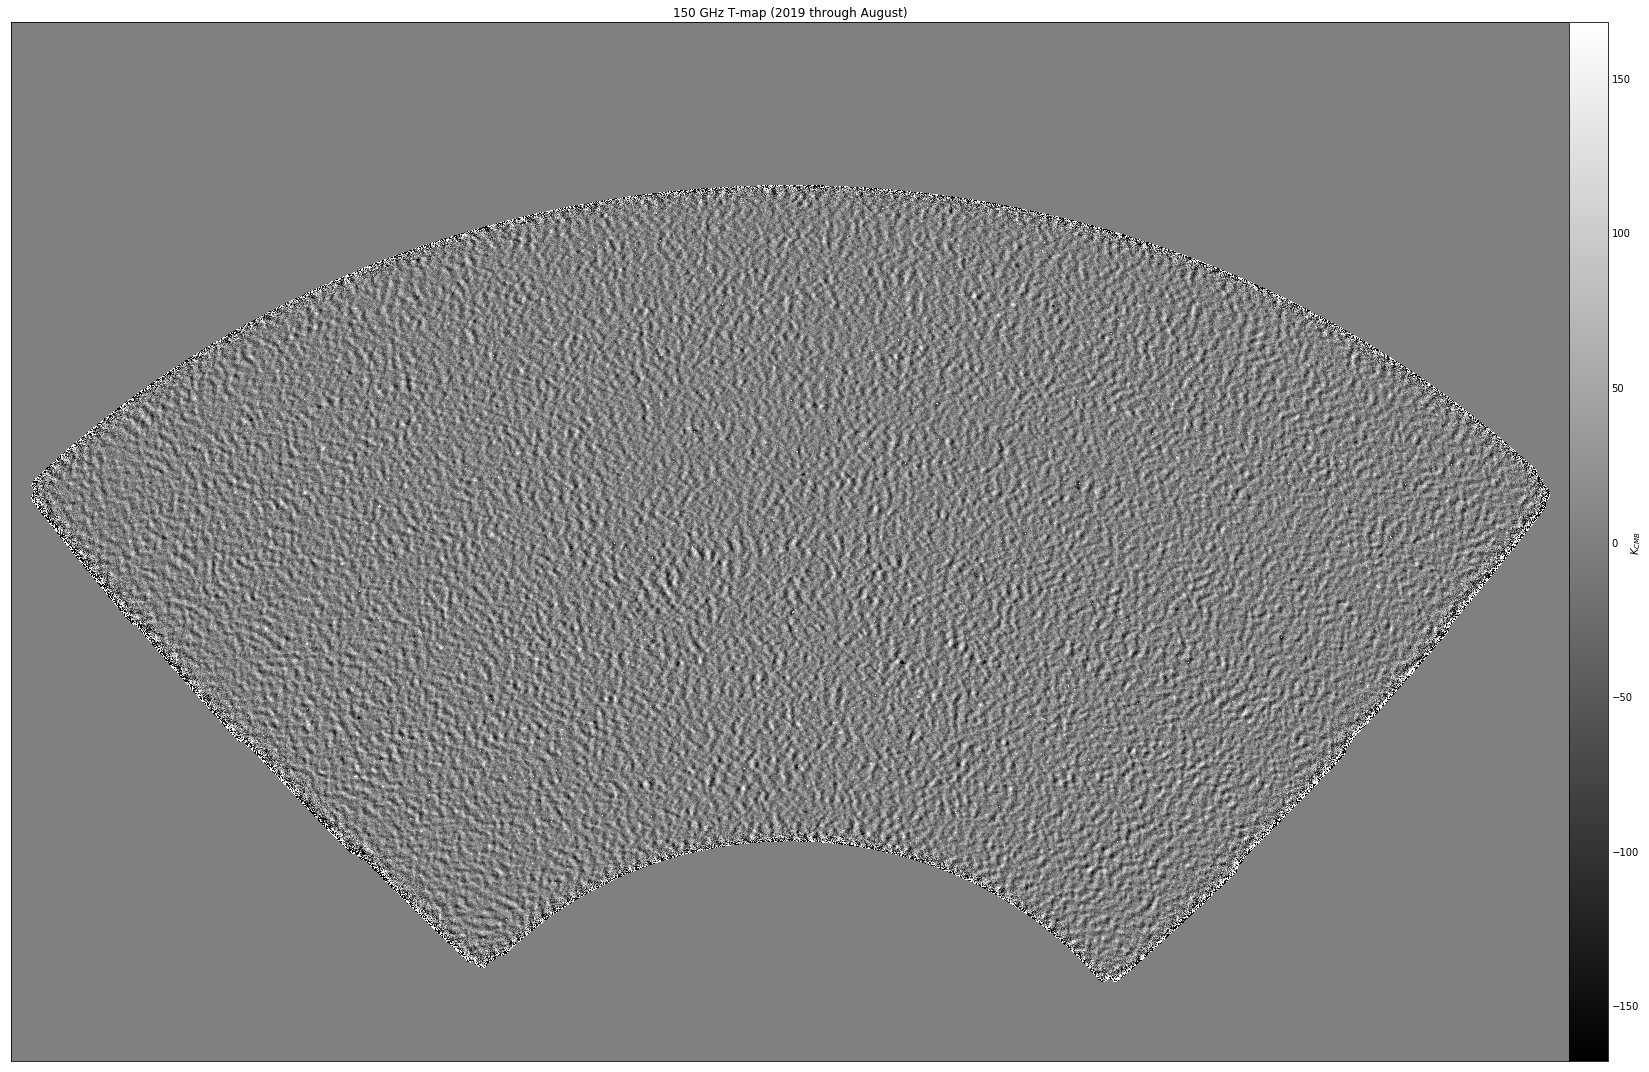

In [12]:
plot_spt3g_map(removed_weights_full_coadd, title="150 GHz T-map (2019 through August)")

# Make apodization map #

In [13]:
from spt3g.mapspectra import apodmask

In [14]:
apod_mask = apodmask.make_border_apodization(full_coadd)

In [15]:
mapmaker.mapmakerutils.save_spt3g_map("/spt/user/joshuasobrin/clusters/2019-08-31_map_products/apod_mask_201906_150.fits", apod_mask, old_style_fits=True)

# Make noise-differenced map #

In [18]:
from spt3g.mapspectra import map_analysis

In [19]:
partial_coadd_a = core.G3File("/spt/user/joshuasobrin/clusters/2019-08-31_map_products/partial_coadd_201906_150_a.g3")
partial_coadd_b = core.G3File("/spt/user/joshuasobrin/clusters/2019-08-31_map_products/partial_coadd_201906_150_b.g3")

partial_coadd_a = partial_coadd_a.next()
partial_coadd_b = partial_coadd_b.next()

In [20]:
noise_differenced_frame = map_analysis.subtract_two_maps(partial_coadd_a, partial_coadd_b,
                                                       divide_by_two=True)

In [21]:
print(type(noise_differenced_frame))
print("")
print(noise_differenced_frame)

<class 'spt3g.core.G3Frame'>

Frame (Map) [
"T" (spt3g.coordinateutils.FlatSkyMap) => 18000 x 12000 (8e+01 x 5e+01 deg) Lambert Azimuthal Equal Area in equatorial coordinates  (Tcmb)
"Wunpol" (spt3g.core.G3SkyMapWeights) => G3SkyMapWeights
]


In [22]:
noise_differenced_map = noise_differenced_frame["T"]

In [23]:
print(type(noise_differenced_map))
print("")
print(noise_differenced_map)

<class 'spt3g.coordinateutils.FlatSkyMap'>

18000 x 12000 (8e+01 x 5e+01 deg) Lambert Azimuthal Equal Area in equatorial coordinates  (Tcmb)


In [24]:
#Save the map in fits-format (in Kelvin-units)
mapmaker.mapmakerutils.save_spt3g_map("/spt/user/joshuasobrin/clusters/2019-08-31_map_products/noise_map_201906_150.fits", noise_differenced_map/core.G3Units.K, old_style_fits=True)

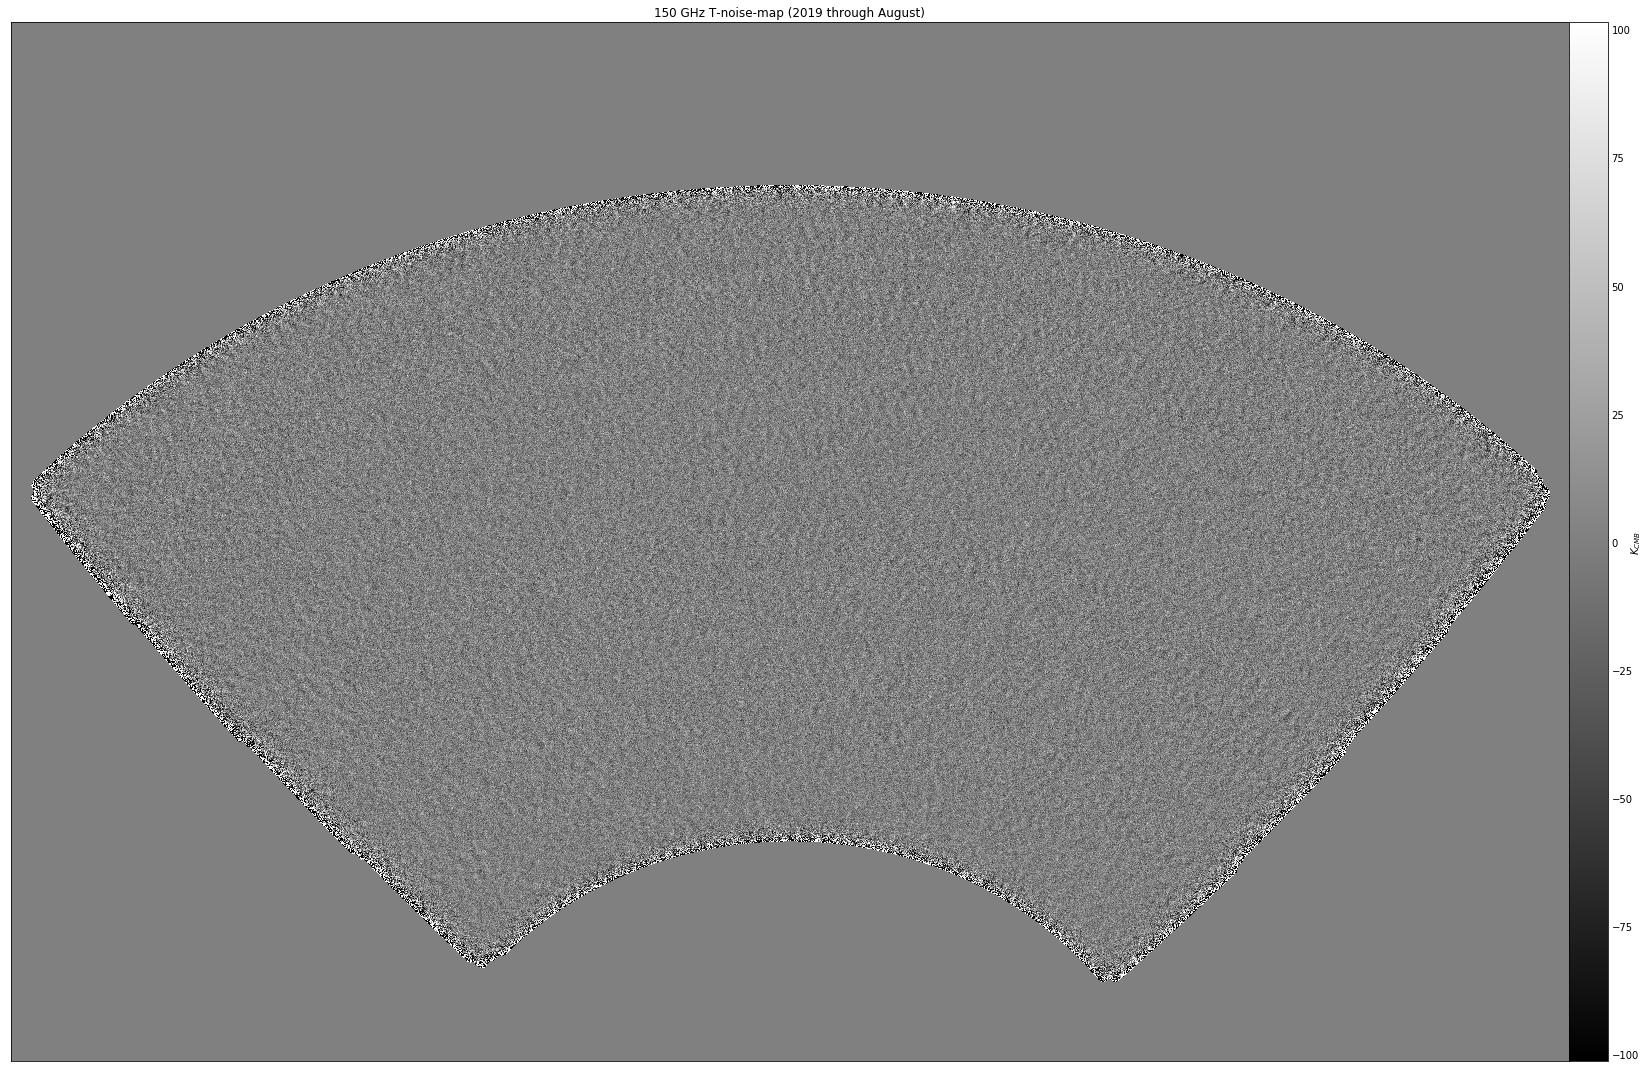

In [25]:
plot_spt3g_map(noise_differenced_map, title="150 GHz T-noise-map (2019 through August)")

# Calculate white-noise level #

In [26]:
cls = map_analysis.calculate_powerspectra(noise_differenced_frame,
                                          delta_l=50, l_min=300, l_max=6000,
                                          apod_mask="from_weight", realimag="real", flatten=False)

In [27]:
bin_centers = cls["TT"].bin_centers

In [28]:
idx = np.where((bin_centers > 3000) & (bin_centers < 5000))[0]

In [29]:
TT_noise = np.sqrt(np.mean(cls["TT"][idx]))/(core.G3Units.arcmin*core.G3Units.uK)

In [30]:
print("White-noise level is", TT_noise, "uK-arcmin at 150 GHz")

White-noise level is 8.18100735081 uK-arcmin at 150 GHz


# Make 2D-PSD of noise map #

In [31]:
noise_PSD_2D = map_analysis.calculate_powerspectra(noise_differenced_frame, return_2d=True,
                                                   delta_l=1, l_min=300, l_max=6000,
                                                   apod_mask="from_weight", flatten=False)

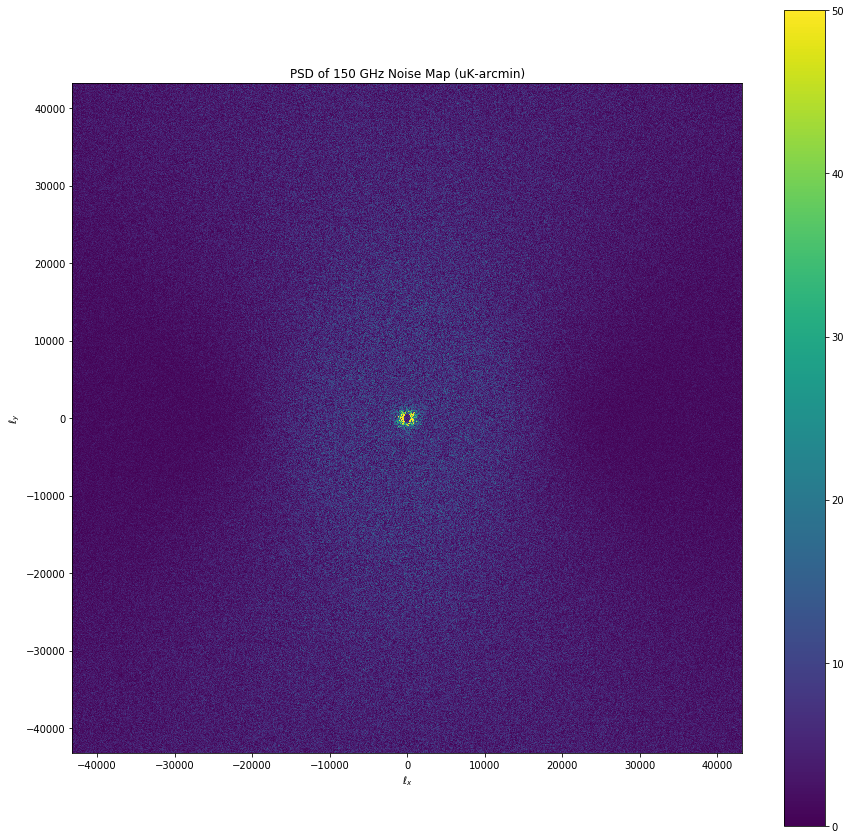

In [32]:
plt.figure(figsize=(15,15))
plt.imshow(np.sqrt(abs(np.fft.fftshift(noise_PSD_2D["TT"])))/(core.G3Units.uK*core.G3Units.arcmin),
           vmin=0, vmax=50, origin="lower", extent=[-43200, 43200, -43200, 43200])
plt.xlabel("$\ell_x$")
plt.ylabel("$\ell_y$")
plt.title("PSD of 150 GHz Noise Map (uK-arcmin)")
plt.colorbar()
plt.show()

In [33]:
reduced_PSD_data = np.asarray(np.sqrt(abs(noise_PSD_2D["TT"]))/(core.G3Units.K))

In [34]:
psd_filename = "/spt/user/joshuasobrin/clusters/2019-08-31_map_products/2D_noise_PSD_150.bin"
fileobj = open(psd_filename, mode='wb')
reduced_PSD_data.tofile(fileobj)
fileobj.close()

# SCRATCH BELOW HERE #

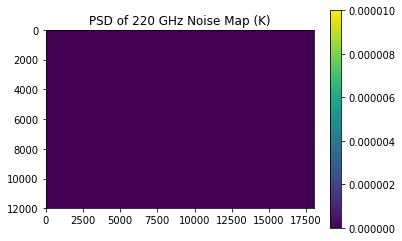

In [34]:
plt.imshow(np.sqrt(abs(noise_PSD_2D["TT"]))/(core.G3Units.K), vmin=0, vmax=10**(-5))
plt.title("PSD of 220 GHz Noise Map (K)")
plt.colorbar()
plt.show()

In [54]:
noise_PSD_2D["TT"].map_nx

18000

In [55]:
np.fft.fftfreq(noise_PSD_2D["TT"].map_nx, noise_PSD_2D["TT"].dx / core.G3Units.rad) * 2.0 * np.pi

array([  0. ,   4.8,   9.6, ..., -14.4,  -9.6,  -4.8])

In [56]:
np.min(np.fft.fftfreq(noise_PSD_2D["TT"].map_nx, noise_PSD_2D["TT"].dx / core.G3Units.rad) * 2.0 * np.pi)

-43200.0

In [57]:
np.max(np.fft.fftfreq(noise_PSD_2D["TT"].map_nx, noise_PSD_2D["TT"].dx / core.G3Units.rad) * 2.0 * np.pi)

43195.199999999997

In [58]:
noise_PSD_2D["TT"].map_ny

12000

In [45]:
np.fft.fftfreq(noise_PSD_2D["TT"].map_ny, noise_PSD_2D["TT"].dx / core.G3Units.rad) * 2.0 * np.pi

array([  0. ,   7.2,  14.4, ..., -21.6, -14.4,  -7.2])

In [46]:
np.min(np.fft.fftfreq(noise_PSD_2D["TT"].map_ny, noise_PSD_2D["TT"].dx / core.G3Units.rad) * 2.0 * np.pi)

-43200.0

In [47]:
np.max(np.fft.fftfreq(noise_PSD_2D["TT"].map_ny, noise_PSD_2D["TT"].dx / core.G3Units.rad) * 2.0 * np.pi)

43192.800000000003

In [65]:
type(noise_PSD_2D["TT"])

spt3g.mapspectra.map_spectrum_classes.MapSpectrum2D

In [17]:
reduced_data = np.asarray(noise_PSD_2D["TT"])

In [18]:
reduced_data.shape

(12000, 18000)